In [1]:
import matplotlib.pyplot as plt
import fraud_detection.viz.model_plots as viz
from fraud_detection.data.loader import DataHandler
from fraud_detection.models.pipeline import build_pipeline
from fraud_detection.models.train import train_and_evaluate
from fraud_detection.models.train import compare_models
from fraud_detection.core.settings import settings

In [2]:
# Test_original Data
test_original = DataHandler.from_registry(
    "DATA", "processed_dir", "test_original.parquet").load()

# Train_original Data
train_original = DataHandler.from_registry(
    "DATA", "processed_dir", "train_original.parquet").load()

# Train_resampled Data
train_resampled = DataHandler.from_registry(
    "DATA", "processed_dir", "train_resampled.parquet").load()

In [3]:
print("Train (original):", train_original.shape)
print("Train (resampled):", train_resampled.shape)
print("Test (original):", test_original.shape)

print("\nClass distribution (original train):")
print(train_original["class"].value_counts(normalize=True))

print("\nClass distribution (resampled train):")
print(train_resampled["class"].value_counts(normalize=True))

Train (original): (120889, 140)
Train (resampled): (219136, 140)
Test (original): (30223, 140)

Class distribution (original train):
class
0    0.906352
1    0.093648
Name: proportion, dtype: float64

Class distribution (resampled train):
class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [4]:
FEATURES = settings.get("features")

TARGET = FEATURES["target"]


X_train_orig = train_original.drop(columns=[TARGET])
y_train_orig = train_original[TARGET]

X_train_res = train_resampled.drop(columns=[TARGET])
y_train_res = train_resampled[TARGET]

X_test = test_original.drop(columns=[TARGET])
y_test = test_original[TARGET]

#### Training and Evalute on Original Data

In [5]:
results = {}
pipe = build_pipeline("logistic_regression")

_, metrics_lr, _ = train_and_evaluate(
    pipeline=pipe,
    X_train=X_train_orig,
    y_train=y_train_orig,
    X_test=X_test,
    y_test=y_test,
    optimize_threshold=True,
    threshold_metric="f1",
)

results["Logistic Regression"] = metrics_lr

d:\10Acadamy\Week 5&6\Tasks\fraud-detection\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2025/12/27 17:09:01 INFO mlflow.tracking.fluent: Experiment with name 'fraud_detection_models' does not exist. Creating a new experiment.


### Train and Evaluate on SMOTE Resampled Data

In [6]:
pipe = build_pipeline("random_forest")

_, metrics_rf, _ = train_and_evaluate(
    pipeline=pipe,
    X_train=X_train_res,
    y_train=y_train_res,
    X_test=X_test,
    y_test=y_test,
    optimize_threshold=True,
    threshold_metric="f1",
)

results["Random Forest"] = metrics_rf

In [7]:
pipe = build_pipeline("xgboost")

_, metrics_xgb, _ = train_and_evaluate(
    pipeline=pipe,
    X_train=X_train_res,
    y_train=y_train_res,
    X_test=X_test,
    y_test=y_test,
    optimize_threshold=True,
    threshold_metric="f1",
)

results["XGBoost"] = metrics_xgb

In [8]:
comparison_df = compare_models(results)
comparison_df

,auc_pr,roc_auc,f1,precision,recall,threshold
model,,,,,,
XGBoost,0.712837,0.840240,0.690428,0.944206,0.544170,0.456518
Random Forest,0.709317,0.840779,0.601399,0.519404,0.714134,0.286489
Logistic Regression,0.649050,0.835967,0.662275,0.874710,0.532862,0.783867


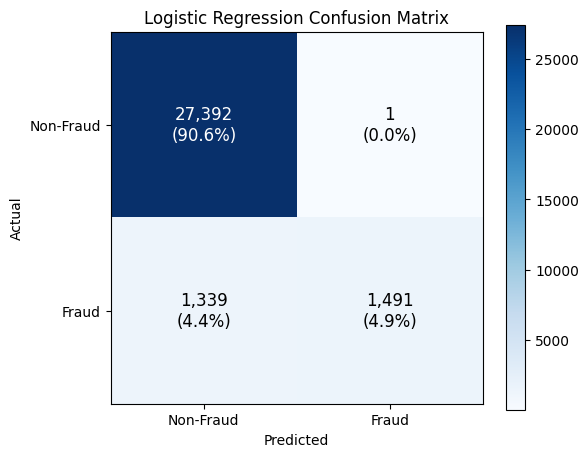

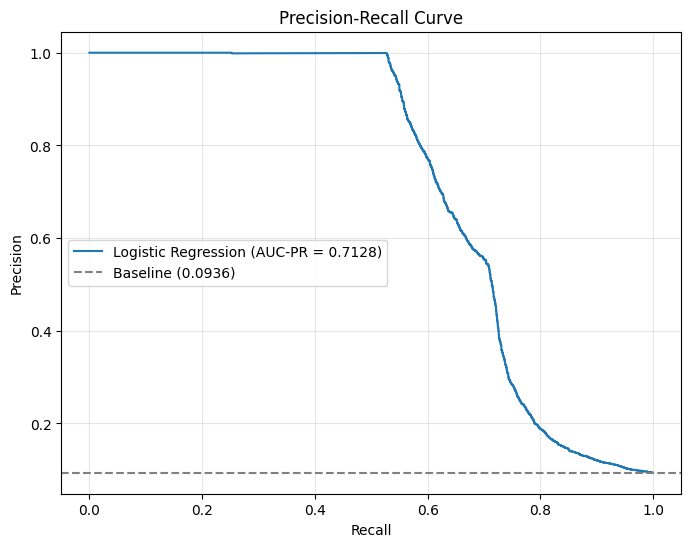

              precision    recall  f1-score       support
Non-Fraud      0.953395  0.999963  0.976124  27393.000000
Fraud          0.999330  0.526855  0.689958   2830.000000
accuracy       0.955663  0.955663  0.955663      0.955663
macro avg      0.976363  0.763409  0.833041  30223.000000
weighted avg   0.957696  0.955663  0.949328  30223.000000


In [9]:
# Predicted probabilities and labels using the optimized threshold
y_proba = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= metrics_lr["threshold"]).astype(int)

# 1️⃣ Confusion Matrix
ax = viz.plot_confusion_matrix(
    y_test.values, y_pred, title="Logistic Regression Confusion Matrix")
plt.show()

# 2️⃣ Precision-Recall Curve
ax = viz.plot_precision_recall_curve(
    y_test.values, y_proba, model_name="Logistic Regression")
plt.show()

# 3️⃣ Classification Report
report_df = viz.get_classification_report_df(y_test.values, y_pred)
print(report_df)